**Variational Autoencoder and Convolutional Neural Network Classifier for Digit Generation and Classification on MNIST**

This code utilizes a Variational Autoencoder (VAE) model to encode and decode images from the MNIST dataset, creating a compressed latent representation of each digit and reconstructing it. Additionally, a Convolutional Neural Network (CNN) classifier is trained on MNIST to classify generated digits. After training, the code enables generating new digits by sampling the latent space and classifying these new images with the CNN model. The generated digits are displayed along with their predicted classification, highlighting the combined use of generative and discriminative models.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
input_dim = 784
hidden_dim = 400
latent_dim = 20
batch_size = 64
learning_rate = 1e-3
epochs = 15


In [ ]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 5516277.78it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 160990.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:49<00:00, 33313.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10519342.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mean, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def loss_function(recon_x, x, mean, logvar):

    x_adjusted = (x.view(-1, 784) + 1) / 2
    BCE = nn.functional.binary_cross_entropy(recon_x, x_adjusted, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
# Training function
def train(model, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mean, logvar = model(data)
        loss = loss_function(recon_batch, data, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    average_loss = train_loss / len(train_loader.dataset)
    print(f'===> Epoch: Average Loss: {average_loss:.4f}')

In [ ]:
# Training the VAE
for epoch in range(epochs):
    train(model, train_loader)


===> Epoch: Average Loss: 143.8856
===> Epoch: Average Loss: 117.7836
===> Epoch: Average Loss: 113.5159
===> Epoch: Average Loss: 111.4895
===> Epoch: Average Loss: 110.2355
===> Epoch: Average Loss: 109.2820
===> Epoch: Average Loss: 108.7022
===> Epoch: Average Loss: 108.1144
===> Epoch: Average Loss: 107.7298
===> Epoch: Average Loss: 107.2842
===> Epoch: Average Loss: 107.0199
===> Epoch: Average Loss: 106.7059
===> Epoch: Average Loss: 106.5419
===> Epoch: Average Loss: 106.3244
===> Epoch: Average Loss: 106.0498


In [ ]:
import torch.nn.functional as F

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Training the classifier
def train_classifier(model, device, train_loader, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

classifier = MNISTClassifier().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
train_classifier(classifier, device, train_loader, optimizer, epochs=5)


Epoch 1, Loss: 0.05064549669623375
Epoch 2, Loss: 0.07287675887346268
Epoch 3, Loss: 0.013592639937996864
Epoch 4, Loss: 0.0009322725236415863
Epoch 5, Loss: 0.003660476068034768


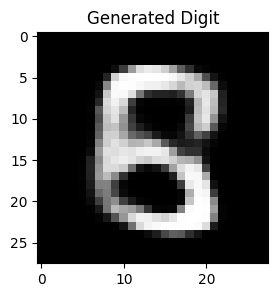

The predicted digit is: 8


In [ ]:
def generate_digit(model, classifier):
    model.eval()
    classifier.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        sample = model.decode(z).to(device)
        plt.figure(figsize=(3, 3))
        plt.imshow(sample.view(28, 28).cpu().numpy(), cmap='gray')
        plt.title("Generated Digit")
        plt.show()


        pred = classifier(sample.view(1, 1, 28, 28))
        predicted_digit = pred.argmax(dim=1, keepdim=True).item()
        print(f"The predicted digit is: {predicted_digit}")

# Generate a new digit and predict
generate_digit(model, classifier)



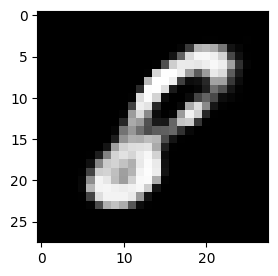

In [ ]:
def generate_digit(model):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        sample = model.decode(z).cpu()
        plt.figure(figsize=(3, 3))
        plt.imshow(sample.view(28, 28), cmap='gray')
        plt.show()

# Generate a new digit
generate_digit(model)